In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
import cv2             # working with, mainly resizing, images
from tqdm import tqdm
from lxml import etree
import xml.etree.ElementTree as ET
import random
import os                  # dealing with directories
import numpy as np
import numpy.ma as ma
import tensorflow as tf

from keras import backend as K
from keras.layers import Conv2D, Add, ZeroPadding2D, UpSampling2D, Concatenate, MaxPooling2D, Input, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras import models
from keras import layers
from keras.layers import Input
from keras.utils.generic_utils import get_custom_objects
#TO DO
#multiple outputs
#code for speed testing
#code for accuracy, pull out categories of unregonized ac
#visualize filters


Using TensorFlow backend.


In [2]:
TRAIN_annot_dir = 'D:/cnntry/air_data/annot_train'
EVAL_annot_dir = 'D:/cnntry/air_data/annot_val'
EVAL_pic_dir = 'D:/cnntry/air_data/valairplane''\\'
img_folder = 'D:/cnntry/air_data/trainairplane'

save_path='D:/cnntry'
DATA_file= 'train_airdata.npy' 

modelpath='my_model.h5'


x_data=np.load('xdata.npy')
y_data=np.load('ydata.npy')

In [13]:
def read_xml(img_name,annot_dir='D:/cnntry/air_data/annot_train'):
    annot_label = img_name.split('.')[0]+'.xml'           #xml file name
    annot_xml = os.path.join(annot_dir,annot_label)  #xml file full path
    root = etree.parse(annot_xml).getroot()
    #for child in root: print(child.tag, child.attrib)        
    img_w= int(root[3][0].text)
    img_h= int(root[3][1].text)
    bb=[]                                   #list for bounding boxes
    for plane in root.iter("object"):
        for l in range(4): bb.append(int(plane[4][l].text)) 
    return img_w, img_h, bb

def rescale_bb(img_w, img_h, bb, ref=(416,416)):
    w_ratio= ref[0] / img_w
    h_ratio= ref[1] / img_h
    for i in range(0,len(bb),2):
        bb[i]= int(bb[i]* w_ratio)
        bb[i+1]= int(bb[i+1]* h_ratio)
    return bb

def conv_bb_coord(bb):
    for i in range(0,len(bb),4):
        x_cen= int( (bb[i]+ bb[i+2])/2)
        y_cen= int( (bb[i+1]+ bb[i+3])/2)
        w= bb[i+2]- bb[i]
        h= bb[i+3]- bb[i+1]
        bb[i],bb[i+1],bb[i+2],bb[i+3]= x_cen, y_cen, w, h
    return bb

def custom_loss(y_true, y_pred, no_object_scale=0.5, bb_scale=5., object_scale=5.):
    shape = y_true.shape #(13,13,5)
    
    #no object loss 
    no_objects_mask = ma.masked_equal(y_true, 0).mask
    no_object_loss = K.sum((0 - (y_pred*no_objects_mask)[:,:,0])**2)
    
    #object loss 
    object_loss = K.sum((1 - (y_pred * ~no_objects_mask)[:,:,0])**2)
    
    # loss from bounding boxes
    bb_loss= K.sum((y_true[:,:,1:] - (y_pred * ~no_objects_mask)[:,:,1:])**2)

    loss= no_object_scale * no_object_loss  +  bb_scale * bb_loss  +  object_loss*object_scale
    #K.print(loss)      
    return loss

def prep_pics(img_folder='D:/cnntry/air_data/trainairplane',ref=(416,416), stop=True, annot_dir='D:/cnntry/air_data/annot_train'):
    training_data = []
    if stop:
        num=400
        x_data=np.zeros((num,416, 416, 3))
        y_data=np.zeros((num,13,13,5))
        
    else:
        x_data=np.zeros((len(os.listdir(img_folder)),416, 416, 3))
        y_data=np.zeros((len(os.listdir(img_folder)),13,13,5))
        
    n=0
    for img in tqdm(os.listdir(img_folder)):
        n=n+1
        if stop and n>num:
            break
        truth= create_truth_arr(conv_bb_coord(rescale_bb(*read_xml(img,annot_dir=annot_dir))))
        path = os.path.join(img_folder,img)
        img = cv2.imread(path)
        img = cv2.resize(img, ref)
        x_data[n-1,...]=np.array(img)
        y_data[n-1,...]=truth
    np.save('x_data.npy', x_data)
    np.save('y_data.npy', y_data)
    return x_data, y_data

def prep_pic(img, ref=(416,416), return_OGimg=True, img_folder='D:/cnntry/air_data/trainairplane'):  #img_folder='D:/cnntry/air_data/trainairplane'
    training_data = []
    x_data=np.zeros((1,ref[0], ref[1], 3))
    #y_data=np.zeros((13,13,5))
    #truth= create_truth_arr(conv_bb_coord(rescale_bb(*read_xml(img))))
    #path = os.path.join(img_folder,'\\')
    path = os.path.join(img_folder,img)
    OGimg = cv2.imread(path)
    img = cv2.resize(OGimg, ref)
    #print()
    x_data[0] = np.array(img)
    if return_OGimg:
        return x_data, OGimg  #np.array of scaled img,  OG cv2 image
    else: return x_data


def create_truth_arr(bb, output_shape=(13,13,5), ref=(416,416)):    #bb[x_cen, y_cen, w, h, x_cen, y_cen, w, h..]
    truth=np.zeros((output_shape))
    box_w= ref[0]/output_shape[0]
    for i in range(0,len(bb),4):
        for j in range(output_shape[0]):
            if bb[i]>= j*box_w  and  bb[i]< (j+1)*box_w:
                a=j
            if bb[i+1]>= j*box_w  and  bb[i+1]< (j+1)*box_w:
                b=j
                
        truth[a,b,0:]= 1,*bb[i:i+4]
        truth[a,b,1]= truth[a,b,1]-(a*box_w)
        truth[a,b,2]= truth[a,b,2]-(b*box_w)
        truth[a,b,1:3]= truth[a,b,1:3]/box_w        
        truth[a,b,3:]= truth[a,b,3:]/ref[1] # [a,b,:]=[1 if plane, 0-1 of where x_cen is in cell, same for y, w/ref width, same for h]
    return truth

def ypred_to_bbs(y_pred, OGshape, threshold, ref=(416,416)):
    shape=y_pred.shape
    scale_w = OGshape[0]/ref[0]
    scale_h = OGshape[1]/ref[1]
    detector_w = ref[0]/shape[0] 
    detector_h = ref[1]/shape[1]
    bbs=[]  #[#detec_x, #detec_y,  0-1 of where x_cen is in cell,   same for y,   w/ref width,   h/ref height]]
    for x in range(shape[0]):
        for y in range(shape[1]):
            if y_pred[x,y,0]>=threshold:
                bbs.append([x,y,*y_pred[x,y,1:]])
    b_b=[]
    for i in bbs:
        x_cen = i[2]*detector_w + i[0]*detector_w
        y_cen = i[3]*detector_h + i[1]*detector_h
        w = i[4]*ref[0]
        h = i[5]*ref[1]
        #print(x_cen, y_cen,w,h)        
        b_b.append([(x_cen-w/2)*scale_w,  (y_cen-h/2)*scale_h,  (x_cen+w/2)*scale_w,  (y_cen+h/2)*scale_h])
        #print(b_b[-1])
        for i in range(len(b_b[-1])):
            if b_b[-1][i]<0.: b_b[-1][i]=0 
            else: b_b[-1][i] = int(b_b[-1][i])
        #print(b_b)
    return b_b  # [x-topleft, y-topleft, x-bottomright, y-bottomright ..repeat]

def viz_output(model, img, t=3, threshold=0.3, plot=False, img_folder='D:/cnntry/air_data/valairplane'):
    x_data, OGimg = prep_pic(img, img_folder=img_folder)
    y_pred = model.predict(x_data)
    #print(y_pred[0].shape)
    img_w, img_h, og_bbs = read_xml(img, annot_dir=EVAL_annot_dir)  #[x-topleft, y-topleft, x-bottomright, y-bottomright ..repeat]
    pred_bbs = ypred_to_bbs(y_pred[0], OGimg.shape, threshold) # [x-topleft, y-topleft, x-bottomright, y-bottomright ..repeat]
    if plot:
        OGimg = cv2.cvtColor(OGimg, cv2.COLOR_BGR2RGB)
        for i in range(0, len(og_bbs), 4):
            tl=(og_bbs[i+0],og_bbs[i+1])
            br=(og_bbs[i+2],og_bbs[i+3])
            OGimg = cv2.rectangle(OGimg,tl,br,(255,0,0),t) #RGB OG bounding boxes are red
        for bb in pred_bbs:
            tl=(bb[0],bb[1])
            br=(bb[2],bb[3])
            OGimg = cv2.rectangle(OGimg,tl,br,(0,255,0),t) #RGB predicted bounding boxes are green    
        plt.imshow(OGimg)   
        plt.show
    else: return x_data, y_pred, og_bbs, pred_bbs, # og_bbs is a straight list and pred_bbs is a list of lists

def eval_centers(model, threshold=0.99, pic_dir='D:/cnntry/air_data/valairplane'):
    true_cen=[] #[[xtrue,ytrue]]
    pred_cen=[] #[[x,y]]
    for img in tqdm(os.listdir(EVAL_pic_dir)):
        x_data, y_pred, og_bbs, pred_bbs = viz_output(model, img, threshold=threshold)
        for i in range(0, len(og_bbs), 4):
            true_cen.append([(og_bbs[i+0]+og_bbs[i+2])/2 , (og_bbs[i+1]+og_bbs[i+3])/2])
        for bb in pred_bbs:
            pred_cen.append([(bb[0]+bb[2])/2 , (bb[1]+bb[3])/2])    
    true_cen = np.asarray(true_cen)
    pred_cen = np.asarray(pred_cen)
    plt.scatter(true_cen[:,0],true_cen[:,1], c='r')
    plt.scatter(pred_cen[:,0],pred_cen[:,1], c='g')
    plt.title('center distribution')
    plt.show
    
    return true_cen
    
    

In [14]:
if True:
    eval_x_data, eval_y_data = prep_pics(img_folder=EVAL_pic_dir, annot_dir=EVAL_annot_dir, stop=False)
    np.save('eval_xdata',eval_x_data)
    np.save('eval_ydata',eval_y_data)

x_data=np.load('eval_xdata.npy')
y_data=np.load('eval_ydata.npy')

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 35.61it/s]


In [15]:
get_custom_objects().update({"custom_loss": custom_loss})
model=models.load_model(modelpath)

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:15<00:00,  6.10it/s]


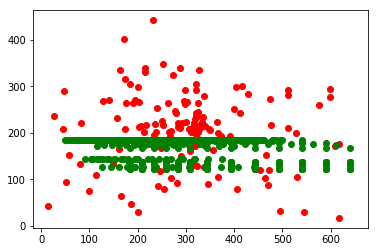

In [197]:
#img = os.listdir(EVAL_pic_dir)

#x_data, OGimg = prep_pic(img[2])
#y_pred = model.predict(x_data)
#pred_bbs = ypred_to_bbs(y_pred[0], OGimg.shape, threshold=0.05)
#print(pred_bbs)

#viz_output(model, img[1001], threshold=0.9995, plot=True)
cen=eval_centers(model, threshold=0.99)

    
    #cv2.imshow('image',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [157]:
ref=(416,416)
shape=(13,13,5)


In [193]:
OGimg = cv2.imread('D:/cnntry/air_data/valairplane\\000000001761.jpg')
print(np.asarray(cen)[:,0])
j='sbsb\sfb'
print(j)
print(j.replace('\\','\\\\'))

[307.5 187.  320.  176.  283.   27.  464.5 333.  618.  174.  267.  148.5
 510.5 189.5 321.5 316.5 345.  350.  202.5 214.5 201.5 246.   57.  324.5
 326.  470.  320.5 276.5 475.5 576.  253.  364.5 282.5 269.5 320.  302.5
 318.  372.  201.5 545.5 325.  316.5 264.5 466.5 114.5 316.  157.  323.5
 453.5 328.5 328.  287.5 296.5  99.5 321.  332.   82.  598.5 609.5 475.
 141.  298.   46.5 242.  283.  322.  269.  325.5 320.  218.  268.  203.5
 284.5  80.5  15.  235.  254.  240.  391.5 246.  530.5 400.  216.  393.
 280.5 404.  206.5 527.5 321.5 309.  184.5 231.5 340.5 195.5 173.5 429.
 510.5 598.5 171.  471.5 310.5 334.5 292.5 320.  366.  300.  328.5 162.5
 129.  406.5 166.  214.  411.5 290.5 318.5 618.  306.5 319.5 249.  282.5
 253.  237.5 510.5 323.   51.  317.  336.5 415.5 263.  161.5 494.5 338.5
 234.  355.5 326.  316.  273.5 347.   45.5 366.  250.5 297.5 287. ]
sbsb\sfb
sbsb\\sfb


In [16]:
get_custom_objects()

{'custom_loss': <function __main__.custom_loss(y_true, y_pred, no_object_scale=0.5, bb_scale=5.0, object_scale=5.0)>}